In [1]:
#This project extracts the daily stock price information from the Yahoo Finance and executes a simple LSTM model which aims to
#predict price based on the extracted data.
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [2]:
#Stock data will be extarcted for the past 10 years for this exercise.
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)

In [3]:
#Please input the tracker symbol (example: 'AAPL' for Apple, 'MSFT' for Microsoft)
ticker = input("Insert a ticker: ") #enter only one ticker without any whitespace
Data = DataReader(ticker, 'yahoo', start, end)
Data['Daily Return'] = Data['Adj Close'].pct_change()
ticker_close = Data.filter(['Close'])
dataset = ticker_close.values
training_data_len = int(np.ceil(len(dataset)*0.8))

Insert a ticker: MSFT


In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [5]:
#Training Data Set
train_data = scaled_data[0:int(training_data_len),:]
x_train = []
y_train = []

for i in range (80,len(train_data)):
    x_train.append(train_data[i-80:i,0])
    y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

#Reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))

In [6]:
#LSTM model
model = Sequential()
model.add(LSTM(80, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(80, return_sequences= False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
1935/1935 [==============================] - 58s 30ms/step - loss: 5.5959e-04
Epoch 2/2
1935/1935 [==============================] - 64s 33ms/step - loss: 4.0743e-04


In [7]:
#Test Dataset
test_data_end = int(np.ceil(len(dataset)*0.2)) + training_data_len
test_data = scaled_data[training_data_len - 80:test_data_end, :]
x_test = []
y_test = dataset[training_data_len:test_data_end, :]
for i in range(80,len(test_data)):
    x_test.append(test_data[i-80:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

test_prediction = model.predict(x_test)
test_prediction = scaler.inverse_transform(test_prediction)
test_error = np.sqrt(np.mean((test_prediction - y_test)**2))
scores = model.evaluate(x_test,y_test, verbose = 0)

train = ticker_close[:training_data_len]
test = ticker_close[training_data_len:test_data_end]
test['Test Predictions'] = test_prediction

<ipython-input-7-f92628769592>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Test Predictions'] = test_prediction


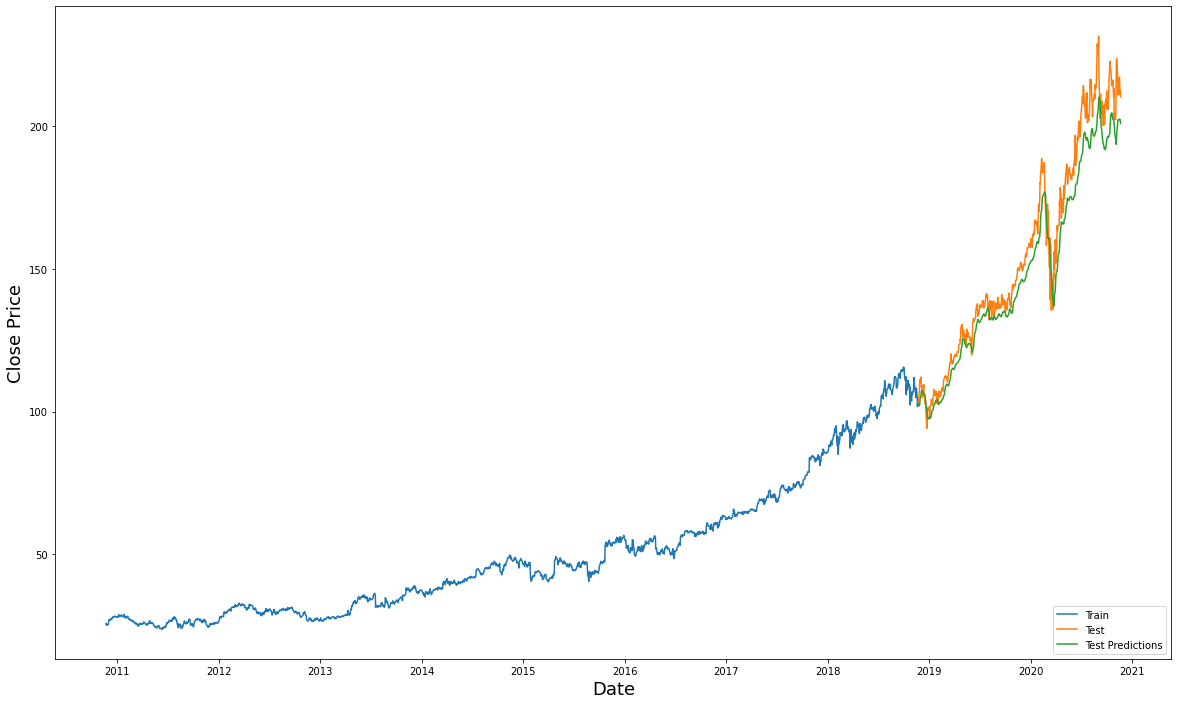

In [8]:
#Result
plt.figure(figsize=(20,12))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(test[['Close', 'Test Predictions']])
plt.legend(['Train', 'Test', 'Test Predictions'], loc='lower right')
plt.show()